# Weather prediction dataset - regression task: tomorrow sunshine hours 

### (Using full 10 years of weather prediction dataset)

Code examples rougly sorted from simple dense neural networks (only dense layers), to more complex networks that include `Dropout` and/or `BatchNormalization` to prevent overfitting.

Second part contains examples on how to apply `Monte-Carlo Dropout` to evaluate the model uncertainty.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
path_root = os.path.dirname(os.getcwd())
path_data = os.path.join(path_root, "dataset")
filename_data = os.path.join(path_data, "weather_prediction_dataset.csv")

In [3]:
data = pd.read_csv(filename_data)
data.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


In [4]:
data.iloc[:5,:5]

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure
0,20000101,1,8,0.89,1.0286
1,20000102,1,8,0.87,1.0318
2,20000103,1,5,0.81,1.0314
3,20000104,1,7,0.79,1.0262
4,20000105,1,5,0.90,1.0246


In [5]:
list({x.split("_")[0] for x in data.columns if x not in ["MONTH", "DATE"]})

['DE',
 'KASSEL',
 'LJUBLJANA',
 'MALMO',
 'PERPIGNAN',
 'ROMA',
 'SONNBLICK',
 'HEATHROW',
 'MONTELIMAR',
 'TOURS',
 'MUENCHEN',
 'STOCKHOLM',
 'BUDAPEST',
 'DUSSELDORF',
 'DRESDEN',
 'MAASTRICHT',
 'OSLO',
 'BASEL']

# Split data into data (X) and labels (y)
We here want to predict the sunshine hours for a particular place (say BASEL which is about in the center of all 18 locations). 

In [6]:
# data
X_data = data.loc[:(data.shape[0]-2)].drop(columns=['DATE', 'MONTH'])

# labels (sunshine hours the next day)
y_data = data.loc[1:]["BASEL_sunshine"]

X_data.shape, y_data.shape

((3653, 163), (3653,))

In [7]:
X_data.head()

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BUDAPEST_cloud_cover,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,3.9,3,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,4.8,8,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,4.8,6,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,7.5,8,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,8.6,5,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


<AxesSubplot:>

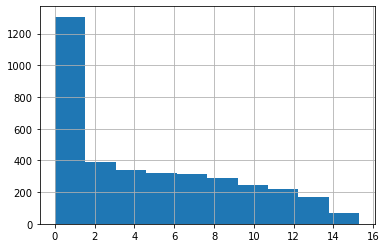

In [8]:
y_data.hist()

# Split data into training, validation, and test set

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0) 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

print(f"Data split into training ({X_train.shape[0]})," \
      f" validation ({X_val.shape[0]}) and test set ({X_test.shape[0]}).") 

Data split into training (2557), validation (548) and test set (548).


In [10]:
# this also shuffled the data!
y_train[:10]

746     0.0
3188    2.8
1982    2.0
3396    6.0
2683    0.2
848     3.3
3328    0.7
1255    8.2
3618    0.1
3082    9.2
Name: BASEL_sunshine, dtype: float64

In [11]:
y_train.max(), y_train.min()

(15.3, 0.0)

# 1) Start simple: Build small neural network

In [12]:
X_train.shape, y_train.shape

((2557, 163), (2557,))

In [13]:
from tensorflow import keras
from tensorflow.keras.models import Model

def create_nn(n_features, n_predictions):
    # Input layer
    input = keras.layers.Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = keras.layers.Dense(10, 'relu')(input)
    layers_dense = keras.layers.Dense(5, 'relu')(layers_dense)

    # Output layer
    output = keras.layers.Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=input, outputs=output, name="weather_prediction_model")

n_features = X_data.shape[1]
n_predictions = 1

model = create_nn(n_features, n_predictions)
model.summary()

Model: "weather_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
dense (Dense)                (None, 10)                1640      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 1,701
Trainable params: 1,701
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss='mse', optimizer=keras.optimizers.Adam(),
              metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=200,
                    verbose=2)

Epoch 1/200
80/80 - 2s - loss: 22.7671 - mae: 3.7007 - root_mean_squared_error: 4.7715
Epoch 2/200
80/80 - 0s - loss: 13.1411 - mae: 3.0352 - root_mean_squared_error: 3.6251
Epoch 3/200
80/80 - 0s - loss: 12.2880 - mae: 2.9084 - root_mean_squared_error: 3.5054
Epoch 4/200
80/80 - 0s - loss: 11.8357 - mae: 2.8455 - root_mean_squared_error: 3.4403
Epoch 5/200
80/80 - 0s - loss: 11.4131 - mae: 2.7945 - root_mean_squared_error: 3.3783
Epoch 6/200
80/80 - 0s - loss: 11.2306 - mae: 2.7621 - root_mean_squared_error: 3.3512
Epoch 7/200
80/80 - 0s - loss: 11.3500 - mae: 2.7680 - root_mean_squared_error: 3.3690
Epoch 8/200
80/80 - 0s - loss: 10.8678 - mae: 2.7089 - root_mean_squared_error: 3.2966
Epoch 9/200
80/80 - 0s - loss: 10.6182 - mae: 2.6649 - root_mean_squared_error: 3.2586
Epoch 10/200
80/80 - 0s - loss: 10.8094 - mae: 2.6902 - root_mean_squared_error: 3.2878
Epoch 11/200
80/80 - 0s - loss: 10.4851 - mae: 2.6510 - root_mean_squared_error: 3.2381
Epoch 12/200
80/80 - 0s - loss: 10.4520 -

Epoch 96/200
80/80 - 0s - loss: 8.4224 - mae: 2.3176 - root_mean_squared_error: 2.9021
Epoch 97/200
80/80 - 0s - loss: 8.4202 - mae: 2.3293 - root_mean_squared_error: 2.9018
Epoch 98/200
80/80 - 0s - loss: 8.4540 - mae: 2.3225 - root_mean_squared_error: 2.9076
Epoch 99/200
80/80 - 0s - loss: 8.3673 - mae: 2.3098 - root_mean_squared_error: 2.8926
Epoch 100/200
80/80 - 0s - loss: 8.2960 - mae: 2.3058 - root_mean_squared_error: 2.8803
Epoch 101/200
80/80 - 0s - loss: 8.5742 - mae: 2.3423 - root_mean_squared_error: 2.9282
Epoch 102/200
80/80 - 0s - loss: 8.3911 - mae: 2.3042 - root_mean_squared_error: 2.8967
Epoch 103/200
80/80 - 0s - loss: 8.2184 - mae: 2.2852 - root_mean_squared_error: 2.8668
Epoch 104/200
80/80 - 0s - loss: 8.2996 - mae: 2.3139 - root_mean_squared_error: 2.8809
Epoch 105/200
80/80 - 0s - loss: 8.5823 - mae: 2.3348 - root_mean_squared_error: 2.9296
Epoch 106/200
80/80 - 0s - loss: 8.1454 - mae: 2.2867 - root_mean_squared_error: 2.8540
Epoch 107/200
80/80 - 0s - loss: 8.2

Epoch 190/200
80/80 - 0s - loss: 7.3241 - mae: 2.1278 - root_mean_squared_error: 2.7063
Epoch 191/200
80/80 - 0s - loss: 7.3919 - mae: 2.1443 - root_mean_squared_error: 2.7188
Epoch 192/200
80/80 - 0s - loss: 7.3887 - mae: 2.1378 - root_mean_squared_error: 2.7182
Epoch 193/200
80/80 - 0s - loss: 7.3594 - mae: 2.1288 - root_mean_squared_error: 2.7128
Epoch 194/200
80/80 - 0s - loss: 7.4118 - mae: 2.1442 - root_mean_squared_error: 2.7225
Epoch 195/200
80/80 - 0s - loss: 7.4677 - mae: 2.1499 - root_mean_squared_error: 2.7327
Epoch 196/200
80/80 - 0s - loss: 7.5434 - mae: 2.1587 - root_mean_squared_error: 2.7465
Epoch 197/200
80/80 - 0s - loss: 7.5197 - mae: 2.1501 - root_mean_squared_error: 2.7422
Epoch 198/200
80/80 - 0s - loss: 7.5749 - mae: 2.1636 - root_mean_squared_error: 2.7523
Epoch 199/200
80/80 - 0s - loss: 7.5092 - mae: 2.1428 - root_mean_squared_error: 2.7403
Epoch 200/200
80/80 - 0s - loss: 7.4874 - mae: 2.1465 - root_mean_squared_error: 2.7363


Text(0, 0.5, 'RMSE')

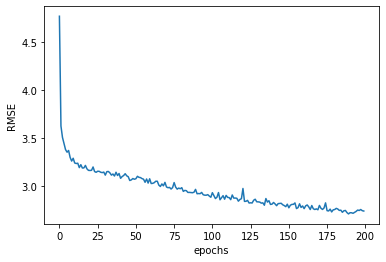

In [15]:
import seaborn as sns

history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df['root_mean_squared_error'])
plt.xlabel("epochs")
plt.ylabel("RMSE")

Text(0.5, 0, 'epochs')

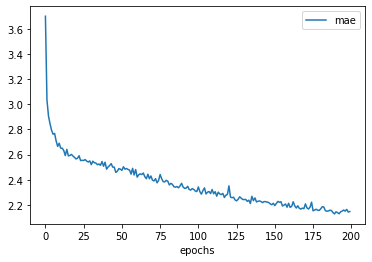

In [16]:
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['mae']])
plt.xlabel("epochs")

## Evaluate the model on the train and the test set

In [17]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

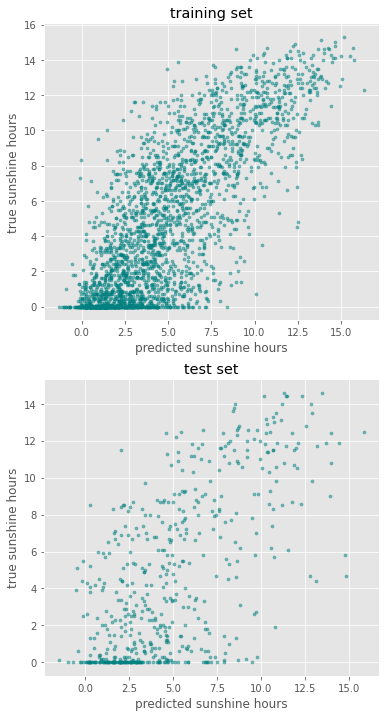

In [18]:
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, figsize=(6, 12))

axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

#plt.savefig("sunshine_tomorrow_training_test_10years.png", dpi=300)
plt.savefig("sunshine_tomorrow_training_test_10years.pdf")

## Use the validation set to monitor the training process

In [19]:
model = create_nn(n_features=X_train.shape[1], n_predictions=1)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "weather_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1640      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 1,701
Trainable params: 1,701
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 200,
                    validation_data=(X_val, y_val), verbose = 2)

Epoch 1/200
80/80 - 3s - loss: 18.1602 - root_mean_squared_error: 4.2615 - val_loss: 15.7884 - val_root_mean_squared_error: 3.9735
Epoch 2/200
80/80 - 0s - loss: 13.5194 - root_mean_squared_error: 3.6769 - val_loss: 14.3917 - val_root_mean_squared_error: 3.7936
Epoch 3/200
80/80 - 0s - loss: 12.3885 - root_mean_squared_error: 3.5197 - val_loss: 12.0289 - val_root_mean_squared_error: 3.4683
Epoch 4/200
80/80 - 0s - loss: 11.8219 - root_mean_squared_error: 3.4383 - val_loss: 11.5714 - val_root_mean_squared_error: 3.4017
Epoch 5/200
80/80 - 0s - loss: 11.4633 - root_mean_squared_error: 3.3858 - val_loss: 11.8062 - val_root_mean_squared_error: 3.4360
Epoch 6/200
80/80 - 0s - loss: 11.1884 - root_mean_squared_error: 3.3449 - val_loss: 10.9466 - val_root_mean_squared_error: 3.3086
Epoch 7/200
80/80 - 0s - loss: 11.1303 - root_mean_squared_error: 3.3362 - val_loss: 10.6961 - val_root_mean_squared_error: 3.2705
Epoch 8/200
80/80 - 0s - loss: 10.8533 - root_mean_squared_error: 3.2944 - val_loss

Epoch 64/200
80/80 - 0s - loss: 9.0801 - root_mean_squared_error: 3.0133 - val_loss: 9.2645 - val_root_mean_squared_error: 3.0438
Epoch 65/200
80/80 - 0s - loss: 8.9164 - root_mean_squared_error: 2.9860 - val_loss: 9.3212 - val_root_mean_squared_error: 3.0531
Epoch 66/200
80/80 - 0s - loss: 9.0141 - root_mean_squared_error: 3.0023 - val_loss: 9.2573 - val_root_mean_squared_error: 3.0426
Epoch 67/200
80/80 - 0s - loss: 8.8457 - root_mean_squared_error: 2.9742 - val_loss: 9.1868 - val_root_mean_squared_error: 3.0310
Epoch 68/200
80/80 - 0s - loss: 8.9283 - root_mean_squared_error: 2.9880 - val_loss: 9.1930 - val_root_mean_squared_error: 3.0320
Epoch 69/200
80/80 - 0s - loss: 8.9374 - root_mean_squared_error: 2.9895 - val_loss: 9.4447 - val_root_mean_squared_error: 3.0732
Epoch 70/200
80/80 - 0s - loss: 8.9339 - root_mean_squared_error: 2.9890 - val_loss: 9.2652 - val_root_mean_squared_error: 3.0439
Epoch 71/200
80/80 - 0s - loss: 8.7281 - root_mean_squared_error: 2.9543 - val_loss: 9.185

Epoch 127/200
80/80 - 0s - loss: 8.3189 - root_mean_squared_error: 2.8842 - val_loss: 9.6228 - val_root_mean_squared_error: 3.1021
Epoch 128/200
80/80 - 0s - loss: 8.3352 - root_mean_squared_error: 2.8871 - val_loss: 9.6302 - val_root_mean_squared_error: 3.1033
Epoch 129/200
80/80 - 0s - loss: 8.3247 - root_mean_squared_error: 2.8852 - val_loss: 9.4175 - val_root_mean_squared_error: 3.0688
Epoch 130/200
80/80 - 0s - loss: 8.2726 - root_mean_squared_error: 2.8762 - val_loss: 10.3752 - val_root_mean_squared_error: 3.2211
Epoch 131/200
80/80 - 0s - loss: 8.2987 - root_mean_squared_error: 2.8807 - val_loss: 9.4677 - val_root_mean_squared_error: 3.0770
Epoch 132/200
80/80 - 0s - loss: 8.2650 - root_mean_squared_error: 2.8749 - val_loss: 9.4294 - val_root_mean_squared_error: 3.0707
Epoch 133/200
80/80 - 0s - loss: 8.2426 - root_mean_squared_error: 2.8710 - val_loss: 9.4460 - val_root_mean_squared_error: 3.0734
Epoch 134/200
80/80 - 0s - loss: 8.3656 - root_mean_squared_error: 2.8923 - val_lo

Epoch 190/200
80/80 - 0s - loss: 7.9241 - root_mean_squared_error: 2.8150 - val_loss: 9.9588 - val_root_mean_squared_error: 3.1558
Epoch 191/200
80/80 - 0s - loss: 8.0145 - root_mean_squared_error: 2.8310 - val_loss: 9.7781 - val_root_mean_squared_error: 3.1270
Epoch 192/200
80/80 - 0s - loss: 7.8061 - root_mean_squared_error: 2.7939 - val_loss: 9.9388 - val_root_mean_squared_error: 3.1526
Epoch 193/200
80/80 - 0s - loss: 7.9818 - root_mean_squared_error: 2.8252 - val_loss: 9.6718 - val_root_mean_squared_error: 3.1100
Epoch 194/200
80/80 - 0s - loss: 7.8477 - root_mean_squared_error: 2.8014 - val_loss: 9.7189 - val_root_mean_squared_error: 3.1175
Epoch 195/200
80/80 - 0s - loss: 7.8756 - root_mean_squared_error: 2.8064 - val_loss: 9.8482 - val_root_mean_squared_error: 3.1382
Epoch 196/200
80/80 - 0s - loss: 7.9523 - root_mean_squared_error: 2.8200 - val_loss: 9.9832 - val_root_mean_squared_error: 3.1596
Epoch 197/200
80/80 - 0s - loss: 7.8421 - root_mean_squared_error: 2.8004 - val_los

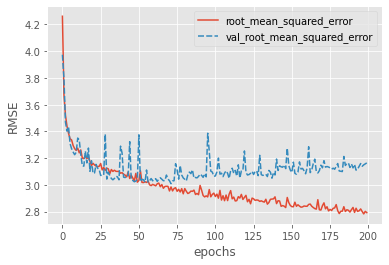

In [21]:
import seaborn as sns

history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")

plt.savefig("training_history_2_rmse_10years.pdf")

## Multiple observations --> somethings wrong with training!
- Severe overfitting! (validation loss >> training loss)
- No smooth learning process: Large jumps in losses over epochs!

# Improve network -> Remedy 1: make network smaler!

In [22]:
def create_nn(n_features, n_predictions):
    # Input layer
    input = keras.layers.Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = keras.layers.Dense(10, 'relu')(input)
    layers_dense = keras.layers.Dense(5, 'relu')(layers_dense)

    # Output layer
    output = keras.layers.Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=input, outputs=output, name="small_prediction_model")

n_features = X_data.shape[1]
n_predictions = 1

model = create_nn(n_features, n_predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "small_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1640      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6         
Total params: 1,701
Trainable params: 1,701
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 200,
                    validation_data=(X_val, y_val), verbose = 2)

Epoch 1/200
80/80 - 1s - loss: 50.5432 - root_mean_squared_error: 7.1094 - val_loss: 13.8132 - val_root_mean_squared_error: 3.7166
Epoch 2/200
80/80 - 0s - loss: 13.3116 - root_mean_squared_error: 3.6485 - val_loss: 13.0044 - val_root_mean_squared_error: 3.6062
Epoch 3/200
80/80 - 0s - loss: 12.5134 - root_mean_squared_error: 3.5374 - val_loss: 12.2810 - val_root_mean_squared_error: 3.5044
Epoch 4/200
80/80 - 0s - loss: 11.9256 - root_mean_squared_error: 3.4533 - val_loss: 11.5527 - val_root_mean_squared_error: 3.3989
Epoch 5/200
80/80 - 0s - loss: 11.5234 - root_mean_squared_error: 3.3946 - val_loss: 11.2432 - val_root_mean_squared_error: 3.3531
Epoch 6/200
80/80 - 0s - loss: 11.4093 - root_mean_squared_error: 3.3778 - val_loss: 11.0920 - val_root_mean_squared_error: 3.3305
Epoch 7/200
80/80 - 0s - loss: 11.0424 - root_mean_squared_error: 3.3230 - val_loss: 11.4018 - val_root_mean_squared_error: 3.3767
Epoch 8/200
80/80 - 0s - loss: 11.0770 - root_mean_squared_error: 3.3282 - val_loss

Epoch 64/200
80/80 - 0s - loss: 9.4079 - root_mean_squared_error: 3.0672 - val_loss: 9.4958 - val_root_mean_squared_error: 3.0815
Epoch 65/200
80/80 - 0s - loss: 9.1837 - root_mean_squared_error: 3.0305 - val_loss: 9.3619 - val_root_mean_squared_error: 3.0597
Epoch 66/200
80/80 - 0s - loss: 9.2411 - root_mean_squared_error: 3.0399 - val_loss: 10.6317 - val_root_mean_squared_error: 3.2606
Epoch 67/200
80/80 - 0s - loss: 9.2283 - root_mean_squared_error: 3.0378 - val_loss: 9.7823 - val_root_mean_squared_error: 3.1277
Epoch 68/200
80/80 - 0s - loss: 9.0458 - root_mean_squared_error: 3.0076 - val_loss: 9.5906 - val_root_mean_squared_error: 3.0969
Epoch 69/200
80/80 - 0s - loss: 8.9710 - root_mean_squared_error: 2.9952 - val_loss: 9.3171 - val_root_mean_squared_error: 3.0524
Epoch 70/200
80/80 - 0s - loss: 9.1040 - root_mean_squared_error: 3.0173 - val_loss: 10.3913 - val_root_mean_squared_error: 3.2236
Epoch 71/200
80/80 - 0s - loss: 9.1853 - root_mean_squared_error: 3.0307 - val_loss: 9.4

Epoch 127/200
80/80 - 0s - loss: 8.0649 - root_mean_squared_error: 2.8399 - val_loss: 9.3515 - val_root_mean_squared_error: 3.0580
Epoch 128/200
80/80 - 0s - loss: 8.1863 - root_mean_squared_error: 2.8612 - val_loss: 9.5042 - val_root_mean_squared_error: 3.0829
Epoch 129/200
80/80 - 0s - loss: 8.3338 - root_mean_squared_error: 2.8868 - val_loss: 9.5177 - val_root_mean_squared_error: 3.0851
Epoch 130/200
80/80 - 0s - loss: 7.9918 - root_mean_squared_error: 2.8270 - val_loss: 9.4403 - val_root_mean_squared_error: 3.0725
Epoch 131/200
80/80 - 0s - loss: 8.0387 - root_mean_squared_error: 2.8353 - val_loss: 9.8051 - val_root_mean_squared_error: 3.1313
Epoch 132/200
80/80 - 0s - loss: 7.9822 - root_mean_squared_error: 2.8253 - val_loss: 9.5946 - val_root_mean_squared_error: 3.0975
Epoch 133/200
80/80 - 0s - loss: 8.3301 - root_mean_squared_error: 2.8862 - val_loss: 9.4997 - val_root_mean_squared_error: 3.0822
Epoch 134/200
80/80 - 0s - loss: 8.0348 - root_mean_squared_error: 2.8346 - val_los

Epoch 190/200
80/80 - 0s - loss: 7.3675 - root_mean_squared_error: 2.7143 - val_loss: 10.5781 - val_root_mean_squared_error: 3.2524
Epoch 191/200
80/80 - 0s - loss: 7.5950 - root_mean_squared_error: 2.7559 - val_loss: 10.1078 - val_root_mean_squared_error: 3.1793
Epoch 192/200
80/80 - 0s - loss: 7.7192 - root_mean_squared_error: 2.7783 - val_loss: 9.7667 - val_root_mean_squared_error: 3.1252
Epoch 193/200
80/80 - 0s - loss: 7.4763 - root_mean_squared_error: 2.7343 - val_loss: 10.1110 - val_root_mean_squared_error: 3.1798
Epoch 194/200
80/80 - 0s - loss: 7.5035 - root_mean_squared_error: 2.7392 - val_loss: 10.4495 - val_root_mean_squared_error: 3.2326
Epoch 195/200
80/80 - 0s - loss: 7.5179 - root_mean_squared_error: 2.7419 - val_loss: 9.9257 - val_root_mean_squared_error: 3.1505
Epoch 196/200
80/80 - 0s - loss: 7.3379 - root_mean_squared_error: 2.7088 - val_loss: 10.1549 - val_root_mean_squared_error: 3.1867
Epoch 197/200
80/80 - 0s - loss: 7.8292 - root_mean_squared_error: 2.7981 - va

Text(0, 0.5, 'RMSE')

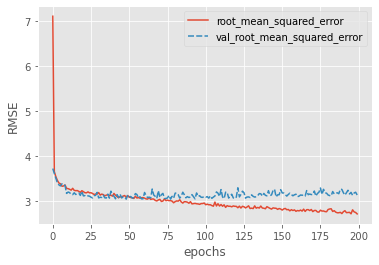

In [24]:
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")

## --> here: works a bit, when size is reduced A LOT! But still clearly overfitting...

# Improve network ->  Remedy 2: early stopping

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=10,
    verbose=1
    )

model = create_nn(n_features=X_train.shape[1], n_predictions=1)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 200,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/200
80/80 - 1s - loss: 15.8642 - root_mean_squared_error: 3.9830 - val_loss: 14.5492 - val_root_mean_squared_error: 3.8143
Epoch 2/200
80/80 - 0s - loss: 13.7137 - root_mean_squared_error: 3.7032 - val_loss: 13.5517 - val_root_mean_squared_error: 3.6813
Epoch 3/200
80/80 - 0s - loss: 13.0565 - root_mean_squared_error: 3.6134 - val_loss: 12.7555 - val_root_mean_squared_error: 3.5715
Epoch 4/200
80/80 - 0s - loss: 12.5156 - root_mean_squared_error: 3.5377 - val_loss: 12.1063 - val_root_mean_squared_error: 3.4794
Epoch 5/200
80/80 - 0s - loss: 12.0599 - root_mean_squared_error: 3.4727 - val_loss: 11.5623 - val_root_mean_squared_error: 3.4003
Epoch 6/200
80/80 - 0s - loss: 11.7269 - root_mean_squared_error: 3.4245 - val_loss: 11.1749 - val_root_mean_squared_error: 3.3429
Epoch 7/200
80/80 - 0s - loss: 11.3386 - root_mean_squared_error: 3.3673 - val_loss: 10.8119 - val_root_mean_squared_error: 3.2881
Epoch 8/200
80/80 - 0s - loss: 11.2015 - root_mean_squared_error: 3.3469 - val_loss

Text(0, 0.5, 'RMSE')

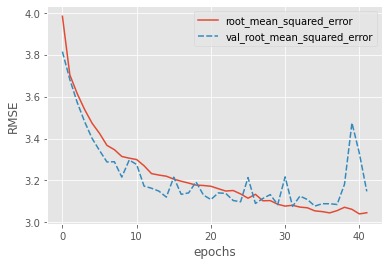

In [26]:
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")

In [27]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

Text(0, 0.5, 'true sunshine hours')

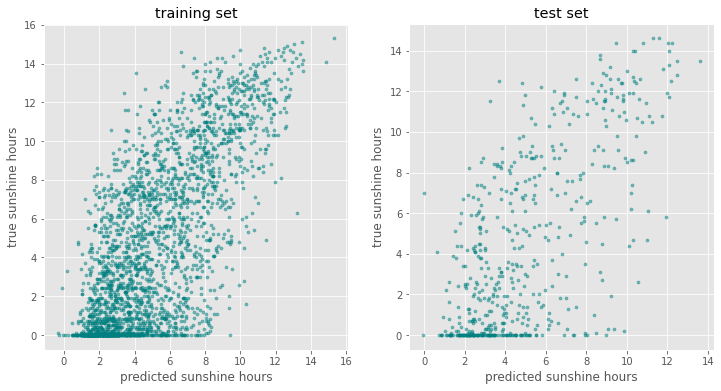

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

# Improve network ->  Remedy 3: add dropout

In [29]:
def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = keras.layers.Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = keras.layers.Dense(100, 'relu')(layers_input)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense)
    layers_dense = keras.layers.Dense(50, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense)

    # Output layer
    layers_output = keras.layers.Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               16400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 21,501
Trainable params: 21,501
Non-trainable params: 0
______________________________________

In [30]:
earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=20,
    verbose=1
    )

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 200,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/200
80/80 - 2s - loss: 18.5869 - root_mean_squared_error: 4.3113 - val_loss: 18.6266 - val_root_mean_squared_error: 4.3159
Epoch 2/200
80/80 - 0s - loss: 14.3119 - root_mean_squared_error: 3.7831 - val_loss: 11.3101 - val_root_mean_squared_error: 3.3630
Epoch 3/200
80/80 - 0s - loss: 13.4448 - root_mean_squared_error: 3.6667 - val_loss: 11.4948 - val_root_mean_squared_error: 3.3904
Epoch 4/200
80/80 - 0s - loss: 13.2191 - root_mean_squared_error: 3.6358 - val_loss: 11.5677 - val_root_mean_squared_error: 3.4011
Epoch 5/200
80/80 - 0s - loss: 12.1730 - root_mean_squared_error: 3.4890 - val_loss: 10.5860 - val_root_mean_squared_error: 3.2536
Epoch 6/200
80/80 - 0s - loss: 12.1317 - root_mean_squared_error: 3.4831 - val_loss: 10.2123 - val_root_mean_squared_error: 3.1957
Epoch 7/200
80/80 - 0s - loss: 11.9967 - root_mean_squared_error: 3.4636 - val_loss: 10.3463 - val_root_mean_squared_error: 3.2166
Epoch 8/200
80/80 - 0s - loss: 12.0764 - root_mean_squared_error: 3.4751 - val_loss

Text(0, 0.5, 'RMSE')

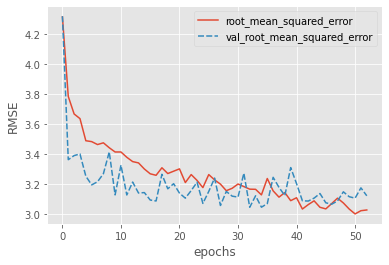

In [31]:
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")

In [32]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

Text(0, 0.5, 'true sunshine hours')

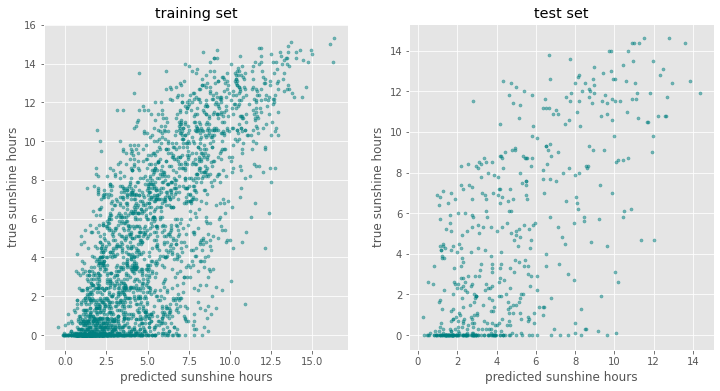

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

# Compare to naive guess: tomorrow has same sunshine hours as today

Text(0, 0.5, 'true sunshine hours')

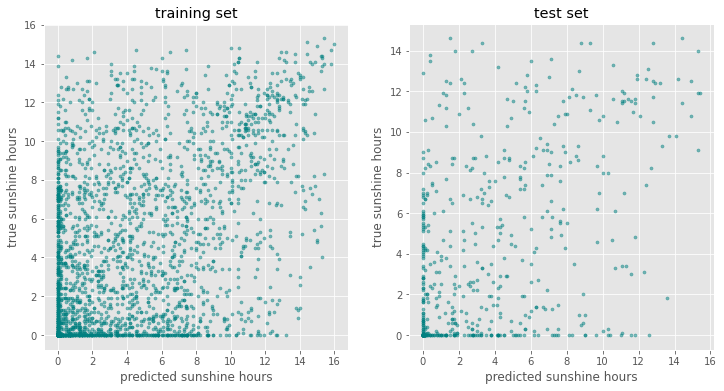

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(X_train["DUSSELDORF_sunshine"], y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(X_test["DUSSELDORF_sunshine"], y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

# Improve network ->  Remedy 4: Use Dropout and BatchNormalization
- ....

In [35]:
def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = keras.layers.Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = keras.layers.BatchNormalization()(layers_input)
    layers_dense = keras.layers.Dense(100, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense)
    layers_dense = keras.layers.Dense(50, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense)
    layers_dense = keras.layers.Dense(10, 'relu')(layers_dense)

    # Output layer
    layers_output = keras.layers.Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 163)               652       
_________________________________________________________________
dense_15 (Dense)             (None, 100)               16400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)   

In [36]:
earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=20,
    verbose=1
    )

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 1000,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/1000
80/80 - 1s - loss: 43.4003 - root_mean_squared_error: 6.5879 - val_loss: 39.4797 - val_root_mean_squared_error: 6.2833
Epoch 2/1000
80/80 - 0s - loss: 37.2499 - root_mean_squared_error: 6.1033 - val_loss: 33.2999 - val_root_mean_squared_error: 5.7706
Epoch 3/1000
80/80 - 0s - loss: 27.9840 - root_mean_squared_error: 5.2900 - val_loss: 22.5560 - val_root_mean_squared_error: 4.7493
Epoch 4/1000
80/80 - 0s - loss: 19.4243 - root_mean_squared_error: 4.4073 - val_loss: 16.1747 - val_root_mean_squared_error: 4.0218
Epoch 5/1000
80/80 - 0s - loss: 16.1046 - root_mean_squared_error: 4.0131 - val_loss: 14.2852 - val_root_mean_squared_error: 3.7796
Epoch 6/1000
80/80 - 0s - loss: 15.4646 - root_mean_squared_error: 3.9325 - val_loss: 13.1396 - val_root_mean_squared_error: 3.6249
Epoch 7/1000
80/80 - 0s - loss: 14.2324 - root_mean_squared_error: 3.7726 - val_loss: 12.2365 - val_root_mean_squared_error: 3.4981
Epoch 8/1000
80/80 - 0s - loss: 13.8217 - root_mean_squared_error: 3.7178 - 

Epoch 64/1000
80/80 - 0s - loss: 9.2678 - root_mean_squared_error: 3.0443 - val_loss: 8.8552 - val_root_mean_squared_error: 2.9758
Epoch 65/1000
80/80 - 0s - loss: 9.1172 - root_mean_squared_error: 3.0195 - val_loss: 8.8321 - val_root_mean_squared_error: 2.9719
Epoch 66/1000
80/80 - 0s - loss: 9.2410 - root_mean_squared_error: 3.0399 - val_loss: 8.8520 - val_root_mean_squared_error: 2.9752
Epoch 67/1000
80/80 - 0s - loss: 9.2682 - root_mean_squared_error: 3.0444 - val_loss: 8.8211 - val_root_mean_squared_error: 2.9700
Epoch 68/1000
80/80 - 0s - loss: 8.9750 - root_mean_squared_error: 2.9958 - val_loss: 8.8886 - val_root_mean_squared_error: 2.9814
Epoch 69/1000
80/80 - 0s - loss: 9.0615 - root_mean_squared_error: 3.0102 - val_loss: 8.8369 - val_root_mean_squared_error: 2.9727
Epoch 70/1000
80/80 - 0s - loss: 9.0173 - root_mean_squared_error: 3.0029 - val_loss: 8.8348 - val_root_mean_squared_error: 2.9723
Epoch 71/1000
80/80 - 0s - loss: 8.5854 - root_mean_squared_error: 2.9301 - val_los

Text(0, 0.5, 'RMSE')

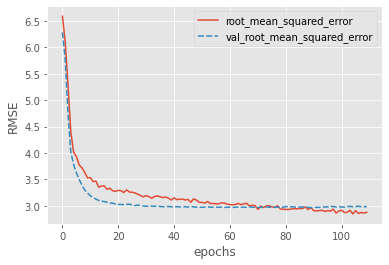

In [37]:
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")

In [38]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

Text(0, 0.5, 'true sunshine hours')

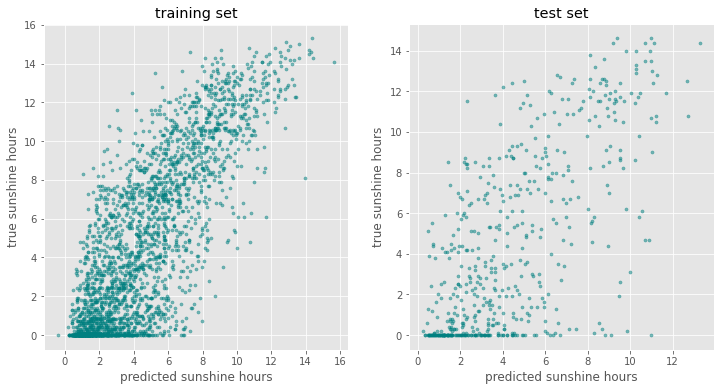

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

## Conclusions:
- lowering learning rate makes training progress smoother
- overfitting is still very clearly visible

# 2) Optional teaching expansion: model uncertainty
## Using Monte-Carlo Dropout to evaluate model uncertainty

In [40]:
def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = keras.layers.Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = keras.layers.BatchNormalization()(layers_input)
    layers_dense = keras.layers.Dense(100, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = keras.layers.Dense(50, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = keras.layers.Dense(10, 'relu')(layers_dense)

    # Output layer
    layers_output = keras.layers.Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 163)               652       
_________________________________________________________________
dense_19 (Dense)             (None, 100)               16400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)   

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=20,
    verbose=1
    )

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 1000,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/1000
80/80 - 2s - loss: 26.9896 - root_mean_squared_error: 5.1952 - val_loss: 17.8013 - val_root_mean_squared_error: 4.2192
Epoch 2/1000
80/80 - 0s - loss: 17.8097 - root_mean_squared_error: 4.2202 - val_loss: 16.1918 - val_root_mean_squared_error: 4.0239
Epoch 3/1000
80/80 - 0s - loss: 15.5183 - root_mean_squared_error: 3.9393 - val_loss: 14.5874 - val_root_mean_squared_error: 3.8193
Epoch 4/1000
80/80 - 0s - loss: 14.2180 - root_mean_squared_error: 3.7707 - val_loss: 13.1547 - val_root_mean_squared_error: 3.6269
Epoch 5/1000
80/80 - 0s - loss: 13.3448 - root_mean_squared_error: 3.6531 - val_loss: 12.6250 - val_root_mean_squared_error: 3.5532
Epoch 6/1000
80/80 - 0s - loss: 12.6560 - root_mean_squared_error: 3.5575 - val_loss: 12.2834 - val_root_mean_squared_error: 3.5048
Epoch 7/1000
80/80 - 0s - loss: 12.3500 - root_mean_squared_error: 3.5143 - val_loss: 10.8467 - val_root_mean_squared_error: 3.2934
Epoch 8/1000
80/80 - 0s - loss: 11.7879 - root_mean_squared_error: 3.4334 - 

Epoch 64/1000
80/80 - 0s - loss: 8.8905 - root_mean_squared_error: 2.9817 - val_loss: 9.2475 - val_root_mean_squared_error: 3.0410
Epoch 65/1000
80/80 - 0s - loss: 8.7506 - root_mean_squared_error: 2.9581 - val_loss: 9.9525 - val_root_mean_squared_error: 3.1548
Epoch 66/1000
80/80 - 0s - loss: 8.9562 - root_mean_squared_error: 2.9927 - val_loss: 9.9080 - val_root_mean_squared_error: 3.1477
Epoch 67/1000
80/80 - 0s - loss: 8.9666 - root_mean_squared_error: 2.9944 - val_loss: 9.5473 - val_root_mean_squared_error: 3.0899
Epoch 68/1000
80/80 - 0s - loss: 9.1109 - root_mean_squared_error: 3.0184 - val_loss: 9.6732 - val_root_mean_squared_error: 3.1102
Epoch 69/1000
80/80 - 0s - loss: 8.8556 - root_mean_squared_error: 2.9758 - val_loss: 9.3879 - val_root_mean_squared_error: 3.0640
Epoch 70/1000
80/80 - 0s - loss: 8.7908 - root_mean_squared_error: 2.9649 - val_loss: 9.8761 - val_root_mean_squared_error: 3.1426
Epoch 71/1000
80/80 - 0s - loss: 8.7843 - root_mean_squared_error: 2.9638 - val_los

Text(0, 0.5, 'RMSE')

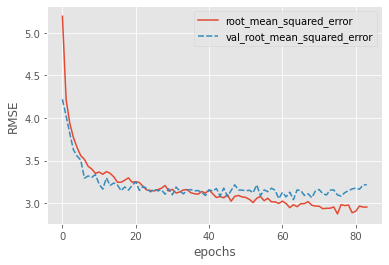

In [42]:
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")

Text(0, 0.5, 'true sunshine hours')

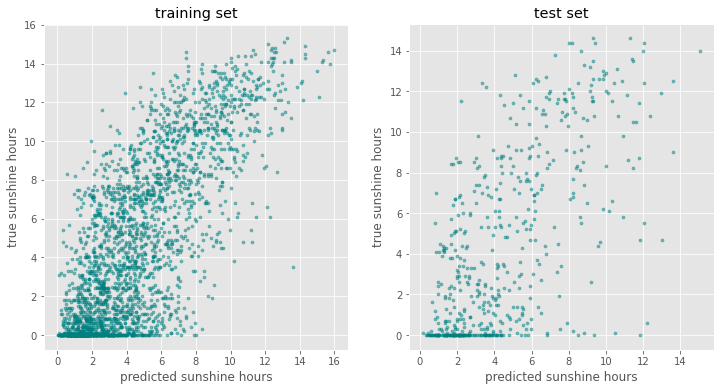

In [43]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

## Compute scores for multiple runs
- The model will look differntly each time due to Dropout randomly removing nodes. This can be seen as a ensemble of slightly different models.

In [44]:
from tqdm.notebook import tqdm

n_ensemble = 100
y_test_predicted_ensemble = np.zeros((X_test.shape[0], n_ensemble))

for i in tqdm(range(n_ensemble)):
    y_test_predicted_ensemble[:, i] = model.predict(X_test)[:,0]

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 1.,  4., 10., 18., 26., 17., 12.,  5.,  5.,  2.]),
 array([2.28121686, 2.72366555, 3.16611423, 3.60856292, 4.05101161,
        4.4934603 , 4.93590899, 5.37835767, 5.82080636, 6.26325505,
        6.70570374]),
 <BarContainer object of 10 artists>)

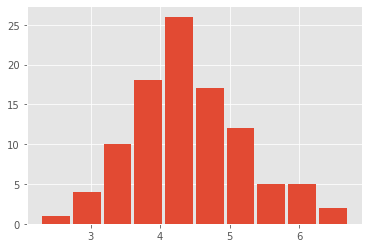

In [45]:
plt.hist(y_test_predicted_ensemble[0,:], rwidth=0.9)

### Take mean and standard deviation of the computed scores

In [46]:
y_test_predicted_mean = np.mean(y_test_predicted_ensemble, axis=1)
y_test_predicted_std = np.std(y_test_predicted_ensemble, axis=1)

In [47]:
y_test_predicted_std.min(), y_test_predicted_std.max()

(0.2439251677072198, 1.9681886305876186)

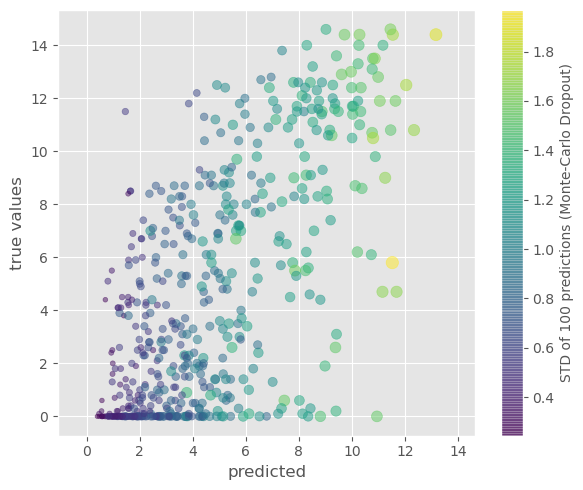

In [48]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.scatter(y_test_predicted_mean, y_test, s=40*y_test_predicted_std, 
            c=y_test_predicted_std, alpha=0.5)
plt.xlabel("predicted")
plt.ylabel("true values")
cbar = plt.colorbar()
cbar.set_label('STD of 100 predictions (Monte-Carlo Dropout)', rotation=90, fontsize=10)

ax.axis("equal")
fig.tight_layout()
#plt.savefig("sunshine_tomorrow_monte_carlo_dropout_10years.png", dpi=300)
plt.savefig("sunshine_tomorrow_monte_carlo_dropout_10years.pdf")

# Same easier to predict labels 1: global radiation

In [49]:
# labels
y_data = data.loc[1:]["BASEL_global_radiation"]

predicted_labelname = "predicted global radiation"
true_labelname = "true global radiation"

# Split data into training, validation, and test set

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0) 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

print(f"Data split into training ({X_train.shape[0]})," \
      f" validation ({X_val.shape[0]}) and test set ({X_test.shape[0]}).") 

Data split into training (2557), validation (548) and test set (548).


In [51]:
# this also shuffled the data!
y_train[:10]

746     0.09
3188    1.30
1982    2.01
3396    2.20
2683    1.20
848     1.84
3328    0.56
1255    2.90
3618    0.27
3082    2.84
Name: BASEL_global_radiation, dtype: float64

In [52]:
y_train.max(), y_train.min()

(3.55, 0.05)

# Build neural network

In [53]:
X_train.shape, y_train.shape

((2557, 163), (2557,))

In [54]:
from tensorflow import keras

def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = keras.layers.Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = keras.layers.BatchNormalization()(layers_input)
    layers_dense = keras.layers.Dense(100, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = keras.layers.Dense(50, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = keras.layers.Dense(10, 'relu')(layers_dense)

    # Output layer
    layers_output = keras.layers.Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 163)               652       
_________________________________________________________________
dense_23 (Dense)             (None, 100)               16400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 10)   

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=20,
    verbose=1
    )

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 1000,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/1000
80/80 - 2s - loss: 0.8207 - root_mean_squared_error: 0.9059 - val_loss: 1.9134 - val_root_mean_squared_error: 1.3832
Epoch 2/1000
80/80 - 0s - loss: 0.6325 - root_mean_squared_error: 0.7953 - val_loss: 0.5784 - val_root_mean_squared_error: 0.7605
Epoch 3/1000
80/80 - 0s - loss: 0.5522 - root_mean_squared_error: 0.7431 - val_loss: 0.4805 - val_root_mean_squared_error: 0.6932
Epoch 4/1000
80/80 - 0s - loss: 0.5113 - root_mean_squared_error: 0.7151 - val_loss: 0.4746 - val_root_mean_squared_error: 0.6889
Epoch 5/1000
80/80 - 0s - loss: 0.4992 - root_mean_squared_error: 0.7065 - val_loss: 0.4308 - val_root_mean_squared_error: 0.6564
Epoch 6/1000
80/80 - 0s - loss: 0.4764 - root_mean_squared_error: 0.6902 - val_loss: 0.4285 - val_root_mean_squared_error: 0.6546
Epoch 7/1000
80/80 - 0s - loss: 0.4431 - root_mean_squared_error: 0.6656 - val_loss: 0.3829 - val_root_mean_squared_error: 0.6188
Epoch 8/1000
80/80 - 0s - loss: 0.4258 - root_mean_squared_error: 0.6526 - val_loss: 0.363

Epoch 64/1000
80/80 - 0s - loss: 0.2586 - root_mean_squared_error: 0.5085 - val_loss: 0.2914 - val_root_mean_squared_error: 0.5399
Epoch 65/1000
80/80 - 0s - loss: 0.2571 - root_mean_squared_error: 0.5071 - val_loss: 0.2661 - val_root_mean_squared_error: 0.5159
Epoch 66/1000
80/80 - 0s - loss: 0.2488 - root_mean_squared_error: 0.4988 - val_loss: 0.3149 - val_root_mean_squared_error: 0.5612
Epoch 67/1000
80/80 - 0s - loss: 0.2521 - root_mean_squared_error: 0.5021 - val_loss: 0.2955 - val_root_mean_squared_error: 0.5436
Epoch 68/1000
80/80 - 0s - loss: 0.2403 - root_mean_squared_error: 0.4902 - val_loss: 0.2738 - val_root_mean_squared_error: 0.5232
Epoch 69/1000
80/80 - 0s - loss: 0.2614 - root_mean_squared_error: 0.5112 - val_loss: 0.2707 - val_root_mean_squared_error: 0.5203
Epoch 70/1000
80/80 - 0s - loss: 0.2529 - root_mean_squared_error: 0.5029 - val_loss: 0.2593 - val_root_mean_squared_error: 0.5092
Epoch 71/1000
80/80 - 0s - loss: 0.2549 - root_mean_squared_error: 0.5049 - val_los

Text(0, 0.5, 'RMSE')

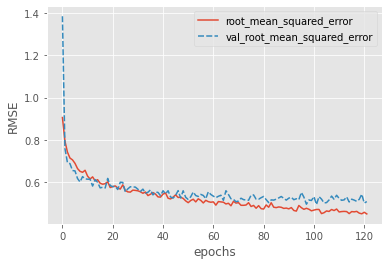

In [56]:
import seaborn as sns
#plt.style.use('ggplot')
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")

Text(0, 0.5, 'true global radiation')

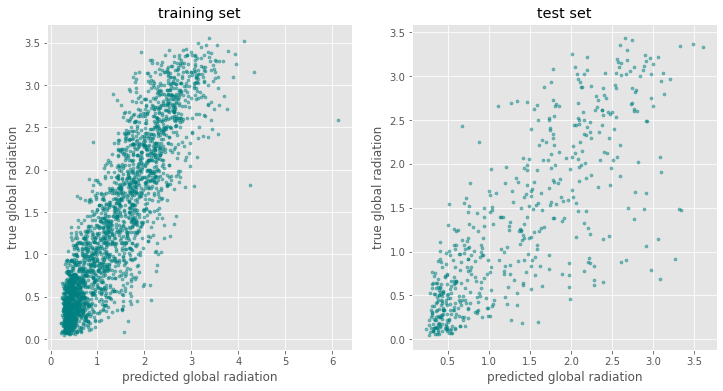

In [57]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel(predicted_labelname)
axes[0].set_ylabel(true_labelname)

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel(predicted_labelname)
axes[1].set_ylabel(true_labelname)

In [58]:
from tqdm.notebook import tqdm

n_ensemble = 100
y_test_predicted_ensemble = np.zeros((X_test.shape[0], n_ensemble))

for i in tqdm(range(n_ensemble)):
    y_test_predicted_ensemble[:, i] = model.predict(X_test)[:,0]

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 2.,  3.,  8., 17., 17., 19., 17.,  9.,  5.,  3.]),
 array([0.40019882, 0.47696872, 0.55373862, 0.63050852, 0.70727842,
        0.78404832, 0.86081822, 0.93758812, 1.01435802, 1.09112792,
        1.16789782]),
 <BarContainer object of 10 artists>)

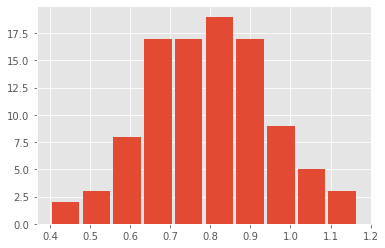

In [59]:
plt.hist(y_test_predicted_ensemble[0,:], rwidth=0.9)

In [60]:
y_test_predicted_mean = np.mean(y_test_predicted_ensemble, axis=1)
y_test_predicted_std = np.std(y_test_predicted_ensemble, axis=1)

In [61]:
y_test_predicted_std.min(), y_test_predicted_std.max()

(0.04361737165705448, 0.5058654865647813)

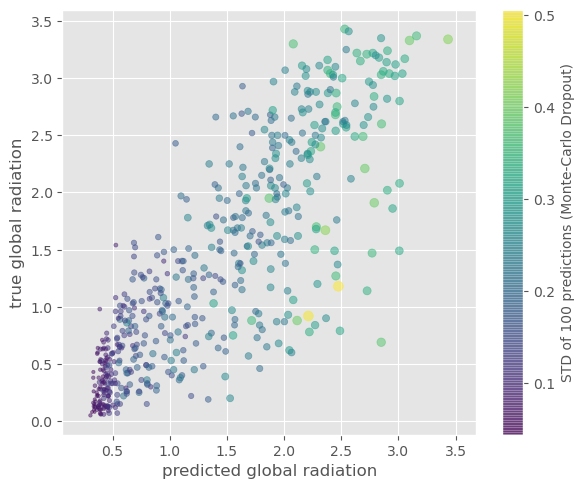

In [62]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.scatter(y_test_predicted_mean, y_test, s=100*y_test_predicted_std, 
            c=y_test_predicted_std, alpha=0.5)
plt.xlabel(predicted_labelname)
plt.ylabel(true_labelname)
cbar = plt.colorbar()
cbar.set_label('STD of 100 predictions (Monte-Carlo Dropout)', rotation=90, fontsize=10)

ax.axis("equal")
fig.tight_layout()
#plt.savefig("global_radiation_tomorrow_monte_carlo_dropout_10years.png", dpi=300)
plt.savefig("global_radiation_tomorrow_monte_carlo_dropout_10years.pdf")

# Same, but for easier to predict labels 2: max temperature

In [63]:
# labels
y_data = data.loc[1:]["BASEL_temp_max"]

predicted_labelname = "predicted max.temperature"
true_labelname = "true max.temperature"

# Split data into training, validation, and test set

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0) 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

print(f"Data split into training ({X_train.shape[0]})," \
      f" validation ({X_val.shape[0]}) and test set ({X_test.shape[0]}).") 

Data split into training (2557), validation (548) and test set (548).


In [65]:
# this also shuffled the data!
y_train[:10]

746      0.6
3188    14.7
1982    20.0
3396    17.8
2683    18.5
848     18.3
3328    12.0
1255    27.1
3618    11.7
3082    24.7
Name: BASEL_temp_max, dtype: float64

In [66]:
y_train.max(), y_train.min()

(38.6, -5.7)

# Build neural network

In [67]:
X_train.shape, y_train.shape

((2557, 163), (2557,))

In [68]:
from tensorflow import keras

def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = keras.layers.Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = keras.layers.BatchNormalization()(layers_input)
    layers_dense = keras.layers.Dense(100, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = keras.layers.Dense(50, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = keras.layers.Dense(10, 'relu')(layers_dense)

    # Output layer
    layers_output = keras.layers.Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 163)               652       
_________________________________________________________________
dense_27 (Dense)             (None, 100)               16400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)   

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=20,
    verbose=1
    )

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 1000,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/1000
80/80 - 1s - loss: 306.5732 - root_mean_squared_error: 17.5092 - val_loss: 262.0343 - val_root_mean_squared_error: 16.1875
Epoch 2/1000
80/80 - 0s - loss: 253.9342 - root_mean_squared_error: 15.9353 - val_loss: 200.6327 - val_root_mean_squared_error: 14.1645
Epoch 3/1000
80/80 - 0s - loss: 169.9381 - root_mean_squared_error: 13.0360 - val_loss: 115.0762 - val_root_mean_squared_error: 10.7274
Epoch 4/1000
80/80 - 0s - loss: 87.2523 - root_mean_squared_error: 9.3409 - val_loss: 65.1985 - val_root_mean_squared_error: 8.0746
Epoch 5/1000
80/80 - 0s - loss: 65.2932 - root_mean_squared_error: 8.0804 - val_loss: 55.8246 - val_root_mean_squared_error: 7.4716
Epoch 6/1000
80/80 - 0s - loss: 55.1033 - root_mean_squared_error: 7.4232 - val_loss: 44.7118 - val_root_mean_squared_error: 6.6867
Epoch 7/1000
80/80 - 0s - loss: 47.2594 - root_mean_squared_error: 6.8745 - val_loss: 39.1160 - val_root_mean_squared_error: 6.2543
Epoch 8/1000
80/80 - 0s - loss: 40.1676 - root_mean_squared_erro

Epoch 63/1000
80/80 - 0s - loss: 12.8175 - root_mean_squared_error: 3.5802 - val_loss: 13.9426 - val_root_mean_squared_error: 3.7340
Epoch 64/1000
80/80 - 0s - loss: 12.3940 - root_mean_squared_error: 3.5205 - val_loss: 12.1217 - val_root_mean_squared_error: 3.4816
Epoch 65/1000
80/80 - 0s - loss: 11.7933 - root_mean_squared_error: 3.4341 - val_loss: 12.2340 - val_root_mean_squared_error: 3.4977
Epoch 66/1000
80/80 - 0s - loss: 12.0664 - root_mean_squared_error: 3.4737 - val_loss: 13.2414 - val_root_mean_squared_error: 3.6389
Epoch 67/1000
80/80 - 0s - loss: 12.2261 - root_mean_squared_error: 3.4966 - val_loss: 13.0012 - val_root_mean_squared_error: 3.6057
Epoch 68/1000
80/80 - 0s - loss: 12.4118 - root_mean_squared_error: 3.5230 - val_loss: 12.6630 - val_root_mean_squared_error: 3.5585
Epoch 69/1000
80/80 - 0s - loss: 11.2086 - root_mean_squared_error: 3.3479 - val_loss: 11.4070 - val_root_mean_squared_error: 3.3774
Epoch 70/1000
80/80 - 0s - loss: 11.7781 - root_mean_squared_error: 3

Text(0, 0.5, 'RMSE')

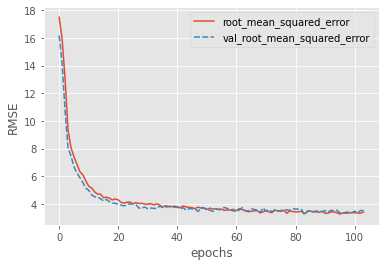

In [70]:
import seaborn as sns
#plt.style.use('ggplot')
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")

Text(0, 0.5, 'true max. temperature')

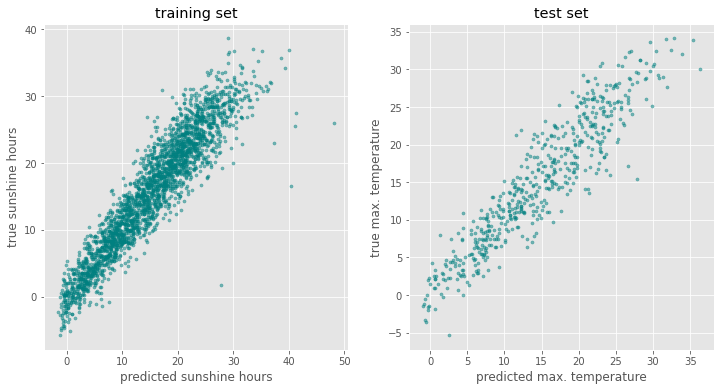

In [71]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted max. temperature")
axes[1].set_ylabel("true max. temperature")

### Compute scores for multiple runs

In [72]:
from tqdm.notebook import tqdm

n_ensemble = 100
y_test_predicted_ensemble = np.zeros((X_test.shape[0], n_ensemble))

for i in tqdm(range(n_ensemble)):
    y_test_predicted_ensemble[:, i] = model.predict(X_test)[:,0]

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 3.,  4.,  8., 15., 14., 23., 11., 13.,  3.,  6.]),
 array([ 9.34610176,  9.98373318, 10.62136459, 11.25899601, 11.89662743,
        12.53425884, 13.17189026, 13.80952168, 14.44715309, 15.08478451,
        15.72241592]),
 <BarContainer object of 10 artists>)

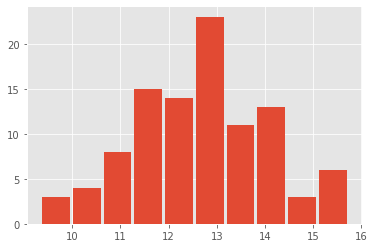

In [73]:
plt.hist(y_test_predicted_ensemble[0,:], rwidth=0.9)

In [74]:
y_test_predicted_mean = np.mean(y_test_predicted_ensemble, axis=1)
y_test_predicted_std = np.std(y_test_predicted_ensemble, axis=1)

In [75]:
y_test_predicted_std.min(), y_test_predicted_std.max()

(0.4368588896388598, 3.3839996162531816)

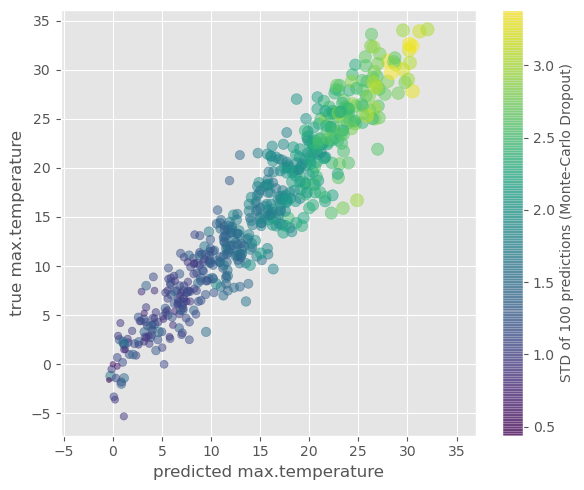

In [77]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.scatter(y_test_predicted_mean, y_test, s=30*y_test_predicted_std, 
            c=y_test_predicted_std, alpha=0.5)
plt.xlabel(predicted_labelname)
plt.ylabel(true_labelname)
cbar = plt.colorbar()
cbar.set_label('STD of 100 predictions (Monte-Carlo Dropout)', rotation=90, fontsize=10)

ax.axis("equal")
fig.tight_layout()
#plt.savefig("max_temp_tomorrow_monte_carlo_dropout_10years.png", dpi=300)
plt.savefig("max_temp_tomorrow_monte_carlo_dropout_10years.pdf")